In [3]:
## RUN THIS CELL TO PROPERLY HIGHLIGHT THE HEADER
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

## Introduction

`Unsupervised models` are trained models using data without labels. Instead of telling an unsupervised algorithm what it should be looking for in the data, the algorithm does the work itself, in a sense independently finding structure within the data.

`K-Means clustering` is an unsupervised learning algorithm that, as the name hints, finds a fixed number ($k$) of `clusters` in a dataset. A cluster is a group of data points that are grouped together due to similarities in their features. When using a `K-Means algorithm`, a cluster is defined by a `centroid`, which is a point (either imaginary or real) at the center of a cluster. Every point in a data set is part of the cluster whose centroid is most closely located. To put it simply, the algorithm finds $k$ number of centroids, and then assigns all data points to the closest cluster, with the aim of keeping the centroids small.

## The Algorithm

We start off by randomly defining $k$ `centroids` (can be an actual data point or it could be a random point). From there, the algorithm proceeds as follows:

1. Assign each data point to the closest corresponding `centroid`, using the standard [`Euclidean distance`](https://en.wikipedia.org/wiki/Euclidean_distance). 
2. For each `centroid`, calculate the average of the values of all the points belonging to it. The mean value becomes the new value of the centroid.

Once step 2 is complete, all of the centroids have new values that correspond to the average of all of their corresponding points. This process is repeated over and over until there is no change in the centroid values, meaning that they have been accurately grouped. Or, the process can be stopped when a previously determined maximum number of steps has been met.

Let's assume we have a set of data points as below

<img class="aligncenter wp-image-3112" src="img/image-1.png" alt="Machine Learning K-Means" width="450" height="350">

**Iteration 1**: First, we create two randomly generated centroids and assign each data point to the cluster of the closest centroid. In this case, because we are using two centroids, our k value is 2.

<img class="aligncenter wp-image-3112" src="img/image-2.png" alt="Machine Learning K-Means" width="450" height="350">

**Iteration 2**: As you can see above, the centroids are not evenly distributed. In the second iteration of the algorithm, the average values of each of the two clusters are found and become the new centroid values.

<img class="aligncenter wp-image-3112" src="img/image-3.png" alt="Machine Learning K-Means" width="450" height="350">

**Iterations 3-5**: We repeat the process until there is no further change in the value of the centroids.

<table><tr>
<td> <img class="alignleft wp-image-3115" src="img/image-4.png" alt="Machine Learning K-Means" width="350" height="300"/> </td>
<td> <img class="alignleft wp-image-3116" src="img/image-5.png" alt="Machine Learning K-Means" width="350" height="300"/> </td>
<td> <img class="alignleft wp-image-3117" src="img/image-6.png" alt="Machine Learning K-Means" width="350" height="300"/> </td>
</tr></table>

Finally, after iteration 5, there is no further change in the clusters.

Now, let's take a look at the visual differences between using $k = 2, 3, 4 \text{ or }5$ clusters.

<p>
    <img class="alignleft wp-image-3115" src="img/9-and-10-attempt-2.jpg" alt="Machine Learning K-Means" width="690" height="650">
    <img class="alignleft wp-image-3117" src="img/10-and-11-attempt-2.jpg" alt="Machine Learning K-Means" width="690" height="650">
</p>

Choosing the optimal $K$ number of `clusters` depends on the problem at hand. There are many methods available to do so:

* [The Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)): This is probably the most well-known method for determining the optimal number of clusters. It is also a bit naive in its approach.
* [The Silhouette Method](https://en.wikipedia.org/wiki/Silhouette_(clustering)): The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation).

`The Elbow Method` is more of a decision rule, while the `Silhouette` is a metric used for validation while clustering. Thus, it can be used in combination with the Elbow Method. Both methods are not alternatives to each other for finding the optimal $K$, rather they are tools to be used together for a more confident decision.

### Mathematical Explanation

$K-$means steps can be computed as follows:

1. Given $N$ data points, $\{x_1,x_2,\cdots,x_N\}$ arrays with real numbers
1. Find $K$ cluster centers, $\{\mu_1,\mu_2,...,\mu_K\}$
1. And assign each data point $x_i$ to one cluster

Please note that, we are using the **Euclidean Norm** to calculate distance between two points. You can find out more about it [here](https://machinelearningmastery.com/vector-norms-machine-learning/)

## Coding Example: Image compression using K-means

In our problem of image compression, K-means algorithm will group similar colors together into $K$ clusters of different colors (RGB values). Therefore, each `cluster centroid` becomes the representative of the three dimensional color vector in RGB color space of its respective cluster.

In [4]:
## loading relevant libraries
import sys
import time

import numpy as np
from numpy.random import seed
from numpy.random import randint
from numpy.random import choice

import pandas as pd
import seaborn as sns
sns.set()

from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
from matplotlib.pyplot import imshow
plt.rcParams['figure.figsize'] = (16, 16)
plt.style.use('default')
%matplotlib inline

print('Python version:', sys.version)
print('Numpy version:', np.__version__)
print('Matplotlib version:', mpl.__version__)

Python version: 3.8.3 (default, May 19 2020, 13:54:14) 
[Clang 10.0.0 ]
Numpy version: 1.18.1
Matplotlib version: 3.1.3


In [11]:
## Initialising centroids
def init_centroid(X, k=5):
    seed(2020)
    samples = choice(len(X), size=k, replace=False)
    return X[samples, :]


## Distance calculations (Euclidean distance)
def dist(X, C):
    return np.linalg.norm(X[:, np.newaxis, :] - C, ord=2, axis=2)**2


## Cluster assignment
def clst_assign(S):
    return np.argmin(S, axis=1)


## Update cluster
def update(X, clst):
    m, d = X.shape
    k = max(clst) + 1
    C_new = np.empty((k, d))
    for v in range(k):
        C_new[v, :d] = np.mean(X[clst == v, :], axis=0)
    return C_new


## Within cluster sum
def WithinClusterSSQ(S):
    return np.sum(np.amin(S, axis=1))


## Applying k-means
def kmeans(X, k=5, C_start=None, max_steps=np.inf, breakloop=False):
    if C_start is None:
        C = init_centroid(X, k)
    else:
        C = C_start
    converged = False
    clusters = np.zeros(len(X))
    labels = np.zeros(len(X))
    i = 1
    while (not converged) and (i <= max_steps):
        C_old = C
        S = dist(X, C)
        labels = clst_assign(S)
        C = update(X, labels)
        converged = np.array_equal(C_old, C)
        i += 1
        if i > 10 & breakloop == True:
            break
    return labels, i, WithinClusterSSQ(S)

### Loading image

In the example below, we will try to load a color image. An color image is usually stored as an $m \times n \times 3$ data array that defines `Red`, `Green`, and `Blue` color components for each individual pixel.

<img class="aligncenter wp-image-3112" src="img/e91171a3-f7ea-411e-a3e1-6d3892b8e1e5.png" alt="Machine Learning K-Means" width="450" height="350">

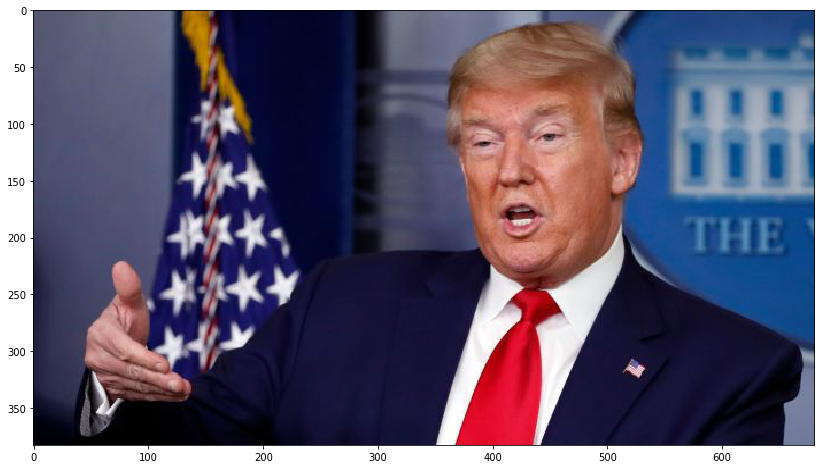

In [5]:
img = Image.open('img/donald-trump-april-2020.jpg')
np_img = np.array(img, dtype='int32')
arr = np_img.astype(dtype='uint8')
img = Image.fromarray(arr, 'RGB')
plt.figure(figsize=(14,8))
imshow(np.asarray(img), aspect='auto')
plt.show()

In [ ]:
print("Dimensions of the matrix is: {} rows x {} columns x depth of {} ".format(
        np_img.shape[0], np_img.shape[1], np_img.shape[2]))

One way we can view this set of pixels is as a cloud of points in a three-dimensional color space. We will
reshape the data to `n_samples x n_features`, and rescale the colors so that they lie between 0 and 1:

In [ ]:
## Reshape the data array
row, col, l = np_img.shape
data = np.reshape(np_img, (row * col, l), order='C')
m, k = data.shape
print("The dimensions of our new data are: {} rows and {} columns".format(m, k))
display(data[:10, :])

### Algorithm implementation

In [ ]:
## Centroids initialization with k=5
C_inits = init_centroid(data, k=5)
print("Initial centroids:\n", C_inits)

In [ ]:
## Distance calculations
M = dist(data, C_inits)
print(M[100:104, ])

In [ ]:
## Cluster Assignment
cluster_labels = clst_assign(M)
print("cluster labels:", np.unique(cluster_labels))

In [ ]:
## Update centroid values
centers = update(data, cluster_labels)
print(centers)

What we may want to do is to find the optimal $K$ value that maximises the _in-between_ cluster distances and minimises the _within_ cluster distances.

In [ ]:
## This cell does take quite a bit of time to run.
## You may want to put a lower number of clusters to try
col_names = ['NumClusters', 'NumIterations', 'WCSSQ']
res_df = pd.DataFrame(columns=col_names)
for i in range(12):
    i += 1
    if i % 2 != 0:
        continue
    new_labels, iteration, WCSSQ = kmeans(data, k=i)
    res_df.loc[len(res_df)] = [i, iteration, WCSSQ]

res_df

In [ ]:
## Plotting the results from the above chunk
ax = plt.gca()
res_df.plot(style='.-', x='NumClusters', y='WCSSQ', color='blue', ax=ax)
plt.show()

Using the `Elbow-method`, **what is the optimal number of clusters?**

In [ ]:
## Let’s have a look at our compressed image
new_labels, iteration, WCSSQ = kmeans(data, k=)
ind = np.column_stack((data, new_labels))
centers = {}
for i in set(new_labels):
    c = ind[ind[:, 3] == i].mean(axis=0)
    centers[i] = c[:3]

img_clustered = np.array([centers[i] for i in new_labels])
img_disp = np.reshape(img_clustered, (row, col, l), order="C")
img_disp = img_disp.astype(dtype='uint8')
new_img = Image.fromarray(img_disp, 'RGB')

fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_subplot(1, 2, 1)
imshow(np.asarray(img))
ax1.title.set_text('Original Image')
ax2 = fig.add_subplot(1, 2, 2)
imshow(np.asarray(new_img))
ax2.title.set_text('Compressed Image')
plt.show(block=True)

**Conclusion**: What is your conclusion?

## Scikit-Learn Implementation

Let’s take a look at how we could go about classifying data using the $K$-Means algorithm with `Python`. 
First thing first, we need to start by importing the required libraries.

In [7]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

In [ ]:
X, y = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
plt.scatter(X[:,0], X[:,1])

In [ ]:
wcss = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 15), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X)
plt.scatter(X[:,0], X[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

## Little Exercise

Assume $K = 2$, say we have the following chart

<img class="alignleft wp-image-3115" src="img/initial_kmeans.png" alt="Machine Learning K-Means" width="690" height="650">

**Question:** After the first iteration, what will be the location of the new centers?